# EXPLORATORY DATA ANALYSIS of FINANCIAL DATA

## Introduction

Financial time series have unique characteristics that differentiate them from other types of data. This notebook performs an exploratory data analysis on stock price data to highlight statistical properties commonly observed in financial markets.

We'll explore:
- Basic statistical properties of returns
- Tests for normality and stationarity
- Autocorrelation patterns in returns and volatility
- Volatility clustering and persistence
- Distribution characteristics across different timeframes

## Data Loading

We'll use the `Stock` class and `loader.py` to retrieve historical price data from Yahoo Finance. The class handles downloading, cleaning, and calculating log returns automatically.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stock import Stock

We can choose any valid ticker symbol for our analysis. The class will download the data from Yahoo Finance using the `yfinance` library.

In [2]:
ticker = 'XOM'
my_stock = Stock(ticker)
my_stock.load_data()

From XOM dataset were removed 23 rows with missing or incorrect data


## Stock Overview

Let's first examine the basic information about our stock data:

In [3]:
print(my_stock.ticker)
print(f"Period: {my_stock.first_date.strftime('%Y-%m-%d')} to {my_stock.last_date.strftime('%Y-%m-%d')}")
print("\nSample of price data:")
print(my_stock.df.head())
print("\nLatest price data:")
print(my_stock.df.tail())

XOM
Period: 1995-01-03 to 2025-03-07

Sample of price data:
                            Open   High    Low  Close   Volume  Dividends  \
Date                                                                        
1995-01-03 00:00:00-05:00  5.870  5.919  5.870  5.882  5018000        0.0   
1995-01-04 00:00:00-05:00  5.894  5.919  5.870  5.907  4128400        0.0   
1995-01-05 00:00:00-05:00  5.894  5.955  5.894  5.919  3958400        0.0   
1995-01-06 00:00:00-05:00  5.919  5.943  5.907  5.919  2716400        0.0   
1995-01-09 00:00:00-05:00  5.882  5.907  5.870  5.870  2576000        0.0   

                           Stock Splits   Returns  Log_Returns  
Date                                                            
1995-01-03 00:00:00-05:00           0.0       NaN          NaN  
1995-01-04 00:00:00-05:00           0.0  0.004250     0.004241  
1995-01-05 00:00:00-05:00           0.0  0.002031     0.002029  
1995-01-06 00:00:00-05:00           0.0  0.000000     0.000000  
1995-01-09

In [5]:
# Display key company information
print("Key Information:")
print("-" * 50)
important_keys = ['shortName', 'country', 'sector', 'industry', 'marketCap', 'beta', 'forwardEps', 'forwardPE']
for key in important_keys:
    if key in my_stock.info:
        print(f"{key}: {my_stock.info[key]}")

Key Information:
--------------------------------------------------
shortName: Exxon Mobil Corporation
country: United States
sector: Energy
industry: Oil & Gas Integrated
marketCap: 473053036544
beta: 0.802
forwardEps: 7.87
forwardPE: 13.852605


In [6]:
# Plot historical prices
fig = my_stock.plot_close(log_scale=True)
if fig:
    fig.show()

## Statistical Properties of Returns

In [7]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Financial prices are non-stationary with trends, so we analyze log returns which are more stationary and better suited for statistical analysis.

In [8]:
stock_returns = my_stock.df['Log_Returns'].dropna()

In [9]:
# Comprehensive statistics
print(f"{my_stock.ticker} Log Returns Analysis, period: {my_stock.first_date.strftime('%Y.%m.%d')} - {my_stock.last_date.strftime('%Y.%m.%d')}")
print("-" * 75)
print(f"Mean:     {stock_returns.mean():.6f}")
print(f"Median:   {stock_returns.median():.6f}")
print(f"Std Dev:  {stock_returns.std():.6f}")
print(f"Skewness: {stock_returns.skew():.6f}")
print(f"Kurtosis: {stock_returns.kurtosis():.6f}")  # Excess kurtosis
print("")
print("A skewness value deviating from zero suggests the distribution is either left-skewed ")
print("(positive skewness) or right-skewed (negative skewness).")
print("Excess kurtosis significantly greater than 0 indicates the presence of heavy tails")
print("in the distribution.")

XOM Log Returns Analysis, period: 1995.01.03 - 2025.03.07
---------------------------------------------------------------------------
Mean:     0.000386
Median:   0.000416
Std Dev:  0.016294
Skewness: -0.052220
Kurtosis: 7.910469

A skewness value deviating from zero suggests the distribution is either left-skewed 
(positive skewness) or right-skewed (negative skewness).
Excess kurtosis significantly greater than 0 indicates the presence of heavy tails
in the distribution.


## Tests for Normality and Stationarity

Financial returns are typically characterized by peculiar features that include non-normal distribution with heavy tails and stationarity. Let's test these properties:

In [10]:
# Normality test (Jarque-Bera)
stat, p_value = stats.jarque_bera(stock_returns.dropna())
print(f"\nJarque-Bera test for normality:")
print(f"p-value: {p_value:.6f}")
print("(p-value close to 0 indicates non-normality)")

# Stationarity test (Augmented Dickey-Fuller)
adf_result = adfuller(stock_returns.dropna())
print(f"\nADF test for stationarity:")
print(f"p-value: {adf_result[1]:.6f}")
print("(p-value close to 0 indicates stationarity)")

# Autocorrelation test (Ljung-Box with lags 5, 10, 15, 20)
lb_result = acorr_ljungbox(stock_returns.dropna(), lags=[5, 10, 15, 20])
print(f"\nLjung-Box test for autocorrelation (lags 5, 10, 15, 20):")  # Tests for autocorrelation in the series
print(f"p-values: {lb_result['lb_pvalue'].values[0]:.6f} (lag 5), {lb_result['lb_pvalue'].values[1]:.6f} (lag 10), \
{lb_result['lb_pvalue'].values[2]:.6f} (lag 15), {lb_result['lb_pvalue'].values[3]:.6f} (lag 20)")
print("(p-value close to 0 indicates presence of autocorrelation)")


Jarque-Bera test for normality:
p-value: 0.000000
(p-value close to 0 indicates non-normality)

ADF test for stationarity:
p-value: 0.000000
(p-value close to 0 indicates stationarity)

Ljung-Box test for autocorrelation (lags 5, 10, 15, 20):
p-values: 0.000000 (lag 5), 0.000000 (lag 10), 0.000000 (lag 15), 0.000000 (lag 20)
(p-value close to 0 indicates presence of autocorrelation)


## Distribution Analysis

A key characteristic of financial returns is their non-normal distribution with heavy tails. Let's visualize this:

Outliers removed: 2


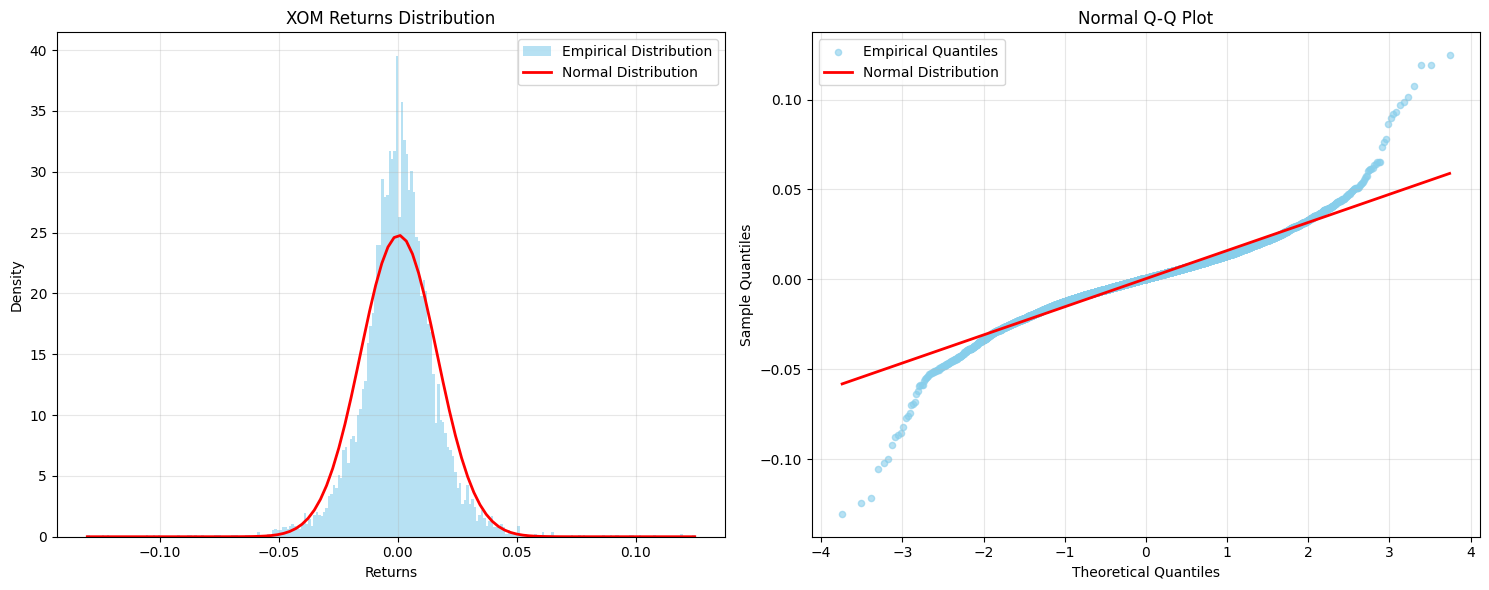

In [11]:
def remove_outliers(data, k=2):
    """
    Helper function to remove outliers using IQR method
    k: multiplier for IQR (default=2 for moderate outlier removal)
    :return: filtered data
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - k * IQR) & (data <= Q3 + k * IQR)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Get both full and filtered data.
full_returns = stock_returns.dropna()
filtered_returns = remove_outliers(full_returns, k=8)

# Decide which data to use (whether the filtered or the full data)
returns = filtered_returns
if len(returns) < len(full_returns):
    print(f"Outliers removed: {len(full_returns) - len(returns)}")

# Left plot: Returns Distribution
hist, bins, _ = ax1.hist(returns.dropna(), bins=250, density=True, 
                        alpha=0.6, color='skyblue', label='Empirical Distribution')

# Add normal distribution curve
x_range = np.linspace(returns.min(), returns.max(), 100)
normal_dist = stats.norm.pdf(x_range, returns.mean(), returns.std())
ax1.plot(x_range, normal_dist, 'r-', lw=2, label='Normal Distribution')

ax1.set_title(f'{my_stock.ticker} Returns Distribution')
ax1.set_xlabel('Returns')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Q-Q Plot
theoretical_quantiles, sample_quantiles = stats.probplot(returns.dropna(), dist="norm")[0]
slope, intercept = np.polyfit(theoretical_quantiles, sample_quantiles, 1)

ax2.scatter(theoretical_quantiles, sample_quantiles, 
           color='skyblue', alpha=0.6, s=20, label='Empirical Quantiles')

ax2.plot(theoretical_quantiles, slope * theoretical_quantiles + intercept, 
         'r-', lw=2, label='Normal Distribution')

ax2.set_title('Normal Q-Q Plot')
ax2.set_xlabel('Theoretical Quantiles')
ax2.set_ylabel('Sample Quantiles')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Time Series Properties: Autocorrelation Analysis

Returns often exhibit little serial correlation, while squared returns (a proxy for volatility) typically show significant autocorrelation - a phenomenon known as volatility clustering.

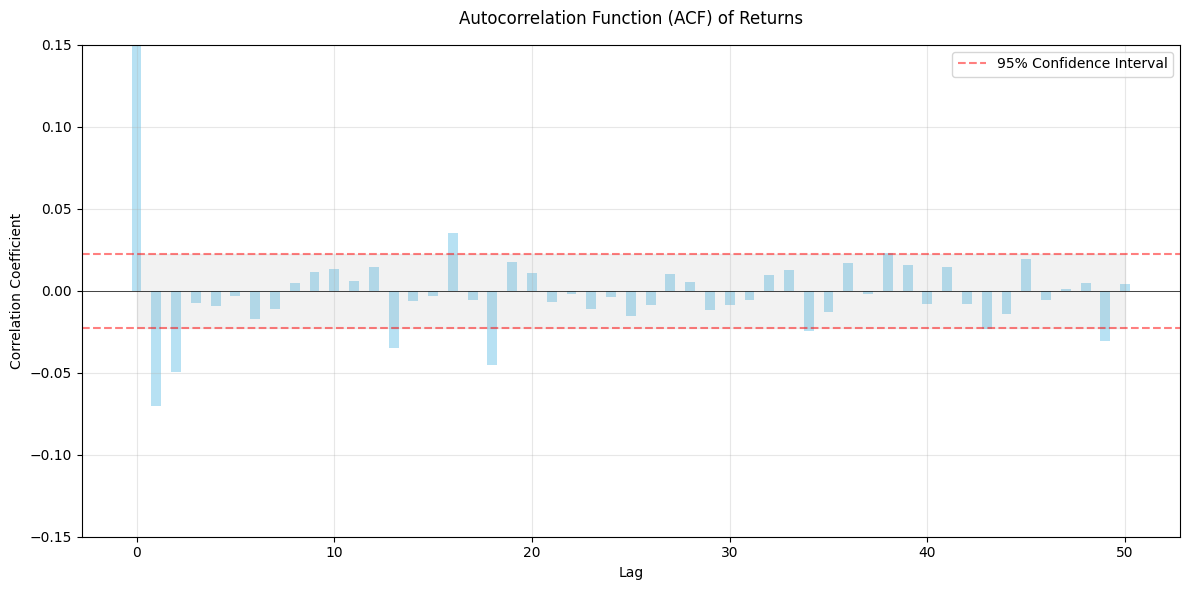


Significant Autocorrelation Lags (95% confidence level: ±0.0225):
-----------------------------------------------------------------
Lag        ACF Value      Direction       Strength
-----------------------------------------------------------------
1            -0.0701       Negative    Very Strong
2            -0.0493       Negative         Strong
13           -0.0347       Negative       Moderate
16            0.0351       Positive       Moderate
18           -0.0455       Negative         Strong
34           -0.0245       Negative       Moderate
38            0.0229       Positive       Moderate
43           -0.0235       Negative       Moderate
49           -0.0307       Negative       Moderate
52           -0.0262       Negative       Moderate
57            0.0245       Positive       Moderate
61            0.0274       Positive       Moderate
73            0.0248       Positive       Moderate

Found 13 significant lags out of 75 tested (17.3%).

Interpretation: Returns show subs

In [13]:
plt.figure(figsize=(12, 6))

# Calculate ACF values (including lag 0)
acf_values = acf(full_returns, nlags=50, fft=True)
lags = np.arange(0, len(acf_values))

# Calculate confidence intervals
# Using 1.96/sqrt(n) for 95% confidence level
n = len(full_returns)
conf_level = 1.96 / np.sqrt(n)

# Create the plot
if len(acf_values) > 50:
    plt.bar(lags, acf_values, width=0.5, color='skyblue', alpha=0.6)
else:
    plt.bar(lags, acf_values, width=0.5, color='skyblue', alpha=0.6)

# Add confidence interval bands
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=conf_level, color='red', linestyle='--', alpha=0.5, 
           label='95% Confidence Interval')
plt.axhline(y=-conf_level, color='red', linestyle='--', alpha=0.5)

# Add shaded confidence interval area
plt.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.1)

plt.title('Autocorrelation Function (ACF) of Returns', pad=15)
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')

# Set y-axis limits
max_acf = max(0.15, max(abs(acf_values[1:])) * 1.2)
plt.ylim(-max_acf, max_acf)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Calculate ACF values (including lag 0)
acf_values = acf(full_returns, nlags=75, fft=True)
lags = np.arange(0, len(acf_values))

# Find significant autocorrelation lags (excluding lag 0)
significant_lags = [(lag, acf_values[lag]) for lag in range(1, len(acf_values)) 
                    if abs(acf_values[lag]) > conf_level]

# Print only significant lags
if significant_lags:
    print(f"\nSignificant Autocorrelation Lags (95% confidence level: ±{conf_level:.4f}):")
    print("-" * 65)
    print(f"{'Lag':<8}{'ACF Value':>12}{'Direction':>15}{'Strength':>15}")
    print("-" * 65)
    
    for lag, value in significant_lags:
        direction = "Positive" if value > 0 else "Negative"
        # Determine strength based on how many times it exceeds the confidence level
        ratio = abs(value) / conf_level
        if ratio >= 3:
            strength = "Very Strong"
        elif ratio >= 2:
            strength = "Strong"
        else:
            strength = "Moderate"
            
        print(f"{lag:<8}{value:>12.4f}{direction:>15}{strength:>15}")
    
    # Calculate percentage of significant lags
    total_lags = len(acf_values) - 1  # Exclude lag 0
    significant_percentage = (len(significant_lags) / total_lags) * 100
    print(f"\nFound {len(significant_lags)} significant lags out of {total_lags} tested ({significant_percentage:.1f}%).")
    
    # Interpretation based on percentage of significant lags
    if significant_percentage >= 15:
        print("\nInterpretation: Returns show substantial serial dependence, suggesting potential")
        print("predictability and possible market inefficiency.")
    elif significant_percentage >= 10:
        print("\nInterpretation: Returns show moderate serial dependence at specific lags,")
        print("which may indicate some predictable patterns.")
    elif significant_percentage >= 5:
        print("\nInterpretation: Returns show limited serial dependence. While some lags are")
        print("statistically significant, the overall pattern suggests weak predictability.")
    else:
        print("\nInterpretation: Returns show minimal serial dependence. Despite a few significant")
        print("lags, the overall pattern is consistent with a largely efficient market.")
    
else:
    print("\nNo significant autocorrelation found at any lag.")
    print("Interpretation: Returns appear to follow a random walk, consistent with market efficiency.")

## Volatility Clustering and Persistence

One of the most prominent features of financial returns is volatility clustering, where large changes tend to be followed by large changes and small changes by small changes.

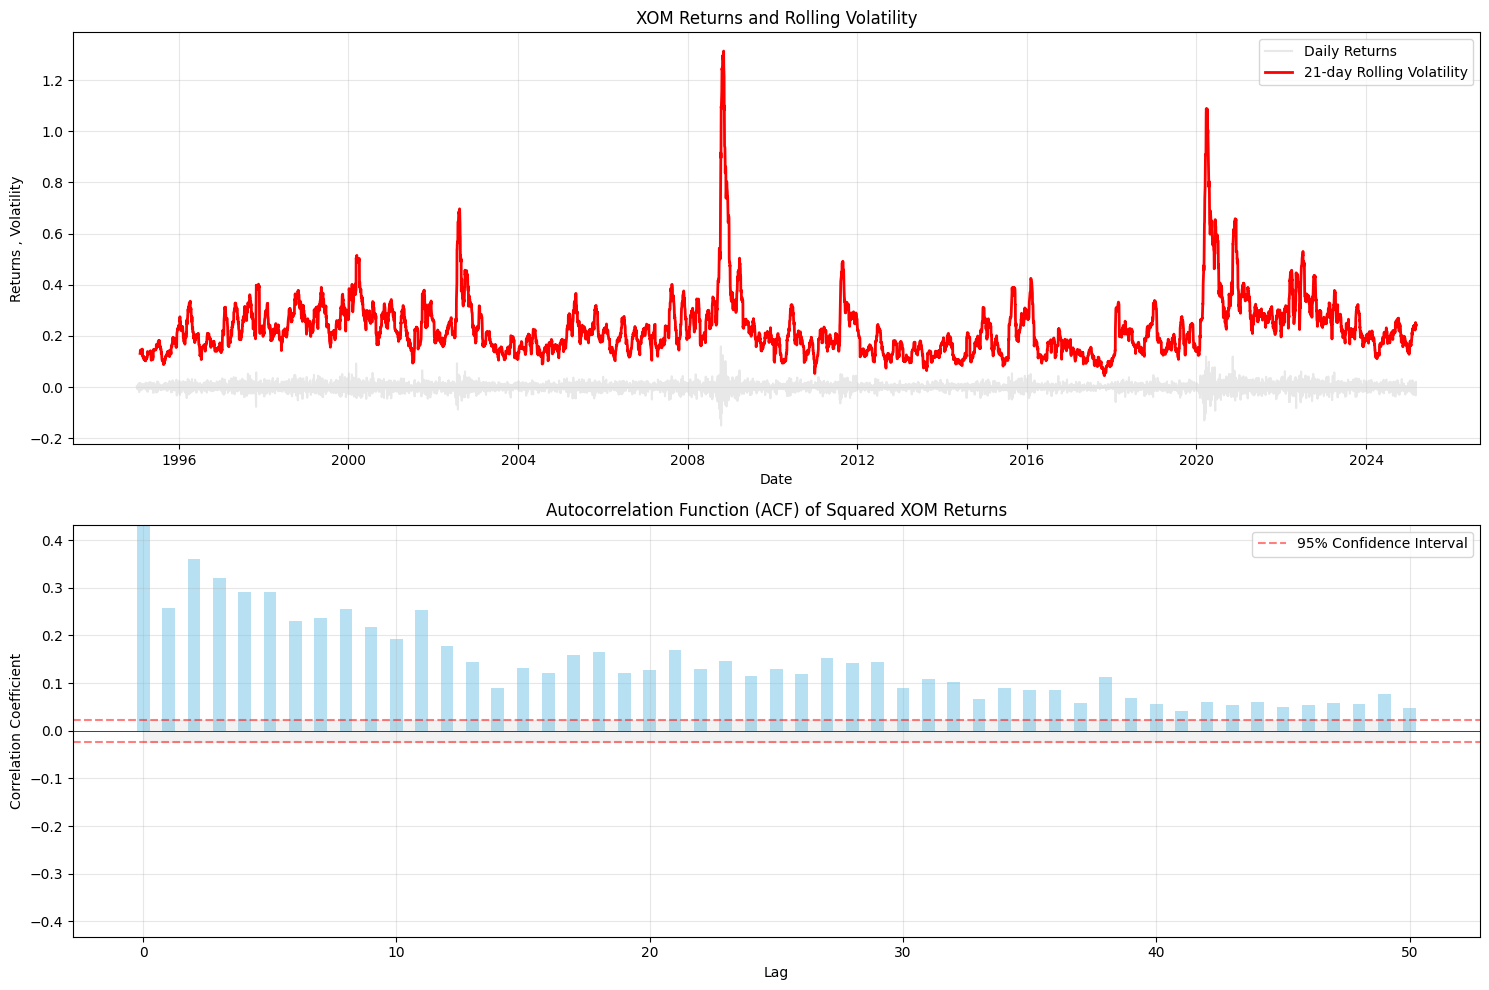

Volatility Autocorrelation Analysis:
-----------------------------------------------------------------
Total significant lags: 96 out of 100 tested (96.0%)
Significant lags in first 25 periods: 25 out of 25 (100.0%)
Longest significant lag: 100

Interpretation: Very strong volatility clustering present - volatility shocks persist
for extended periods, a classic feature of financial time series.


In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Returns and Rolling Volatility
window = 21  # approximately one trading month
rolling_vol = full_returns.rolling(window=window).std() * np.sqrt(252)  # annualized

ax1.plot(full_returns.index, full_returns, color='lightgray', alpha=0.5, label='Daily Returns')
ax1.plot(rolling_vol.index, rolling_vol, color='red', linewidth=2, label=f'{window}-day Rolling Volatility')
ax1.set_title(f'{my_stock.ticker} Returns and Rolling Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('Returns , Volatility')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Custom ACF of Squared Returns
squared_returns = full_returns.dropna()**2
acf_values = acf(squared_returns, nlags=50, fft=True)
lags = np.arange(0, len(acf_values))

# Calculate confidence intervals
n = len(squared_returns)
conf_level = 1.96 / np.sqrt(n)

# Create the bar plot
ax2.bar(lags, acf_values, width=0.5, color='skyblue', alpha=0.6)

# Add confidence interval bands
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=conf_level, color='red', linestyle='--', alpha=0.5, 
            label='95% Confidence Interval')
ax2.axhline(y=-conf_level, color='red', linestyle='--', alpha=0.5)

# Add shaded confidence interval area
ax2.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.1)

# Set titles and labels
ax2.set_title(f'Autocorrelation Function (ACF) of Squared {my_stock.ticker} Returns')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation Coefficient')

# Set y-axis limits
max_acf = max(0.15, max(abs(acf_values[1:])) * 1.2)
ax2.set_ylim(-max_acf, max_acf)

ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Re-calculate ACF for more lags
acf_sq_values = acf(squared_returns, nlags=100, fft=True)

# Find significant autocorrelation lags for squared returns
significant_sq_lags = [(lag, acf_sq_values[lag]) for lag in range(1, len(acf_sq_values)) 
                      if abs(acf_sq_values[lag]) > conf_level]

# Count how many of the first 25 lags are significant
first_25_significant = sum(1 for lag, _ in significant_sq_lags if lag <= 25)
first_25_percentage = (first_25_significant / 25) * 100

# Count total significant lags
total_sq_lags = len(acf_sq_values) - 1  # Exclude lag 0
significant_sq_percentage = (len(significant_sq_lags) / total_sq_lags) * 100

# Print summary of significant lags
print(f"Volatility Autocorrelation Analysis:")
print("-" * 65)
print(f"Total significant lags: {len(significant_sq_lags)} out of {total_sq_lags} tested ({significant_sq_percentage:.1f}%)")
print(f"Significant lags in first 25 periods: {first_25_significant} out of 25 ({first_25_percentage:.1f}%)")
print(f"Longest significant lag: {max([lag for lag, _ in significant_sq_lags]) if significant_sq_lags else 'None'}")

# Interpretation based on findings with more nuanced thresholds for squared returns
# For squared returns, we expect higher autocorrelation, so thresholds are higher
if first_25_percentage >= 80:
    print("\nInterpretation: Very strong volatility clustering present - volatility shocks persist")
    print("for extended periods, a classic feature of financial time series.")
elif first_25_percentage >= 60:
    print("\nInterpretation: Strong volatility clustering present - volatility shocks have")
    print("substantial persistence, typical of many financial markets.")
elif first_25_percentage >= 40:
    print("\nInterpretation: Moderate volatility clustering present - volatility tends to")
    print("cluster but may dissipate more quickly than in highly persistent markets.")
elif first_25_percentage >= 20:
    print("\nInterpretation: Weak volatility clustering - some short-term persistence in volatility,")
    print("but less pronounced than typically observed in financial markets.")
else:
    print("\nInterpretation: Minimal volatility clustering detected - unusual for financial markets,")
    print("suggesting either very rapid mean reversion or potential data issues.")

In [15]:
# Test for ARCH effects (formal test for volatility clustering)
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(full_returns, nlags=10)
print(f"ARCH LM Test (lag 10): stat={lm_stat:.4f}, p-value={lm_pvalue:.6f}")
print("Null hypothesis: No ARCH effects present")
print(f"Interpretation: {'Reject null - ARCH effects present' if lm_pvalue < 0.05 else 'Cannot reject null hypothesis'}")

ARCH LM Test (lag 10): stat=1705.5192, p-value=0.000000
Null hypothesis: No ARCH effects present
Interpretation: Reject null - ARCH effects present


## Leverage Effect Analysis

The leverage effect is an asymmetry where volatility tends to increase more following negative returns than positive returns of the same magnitude.

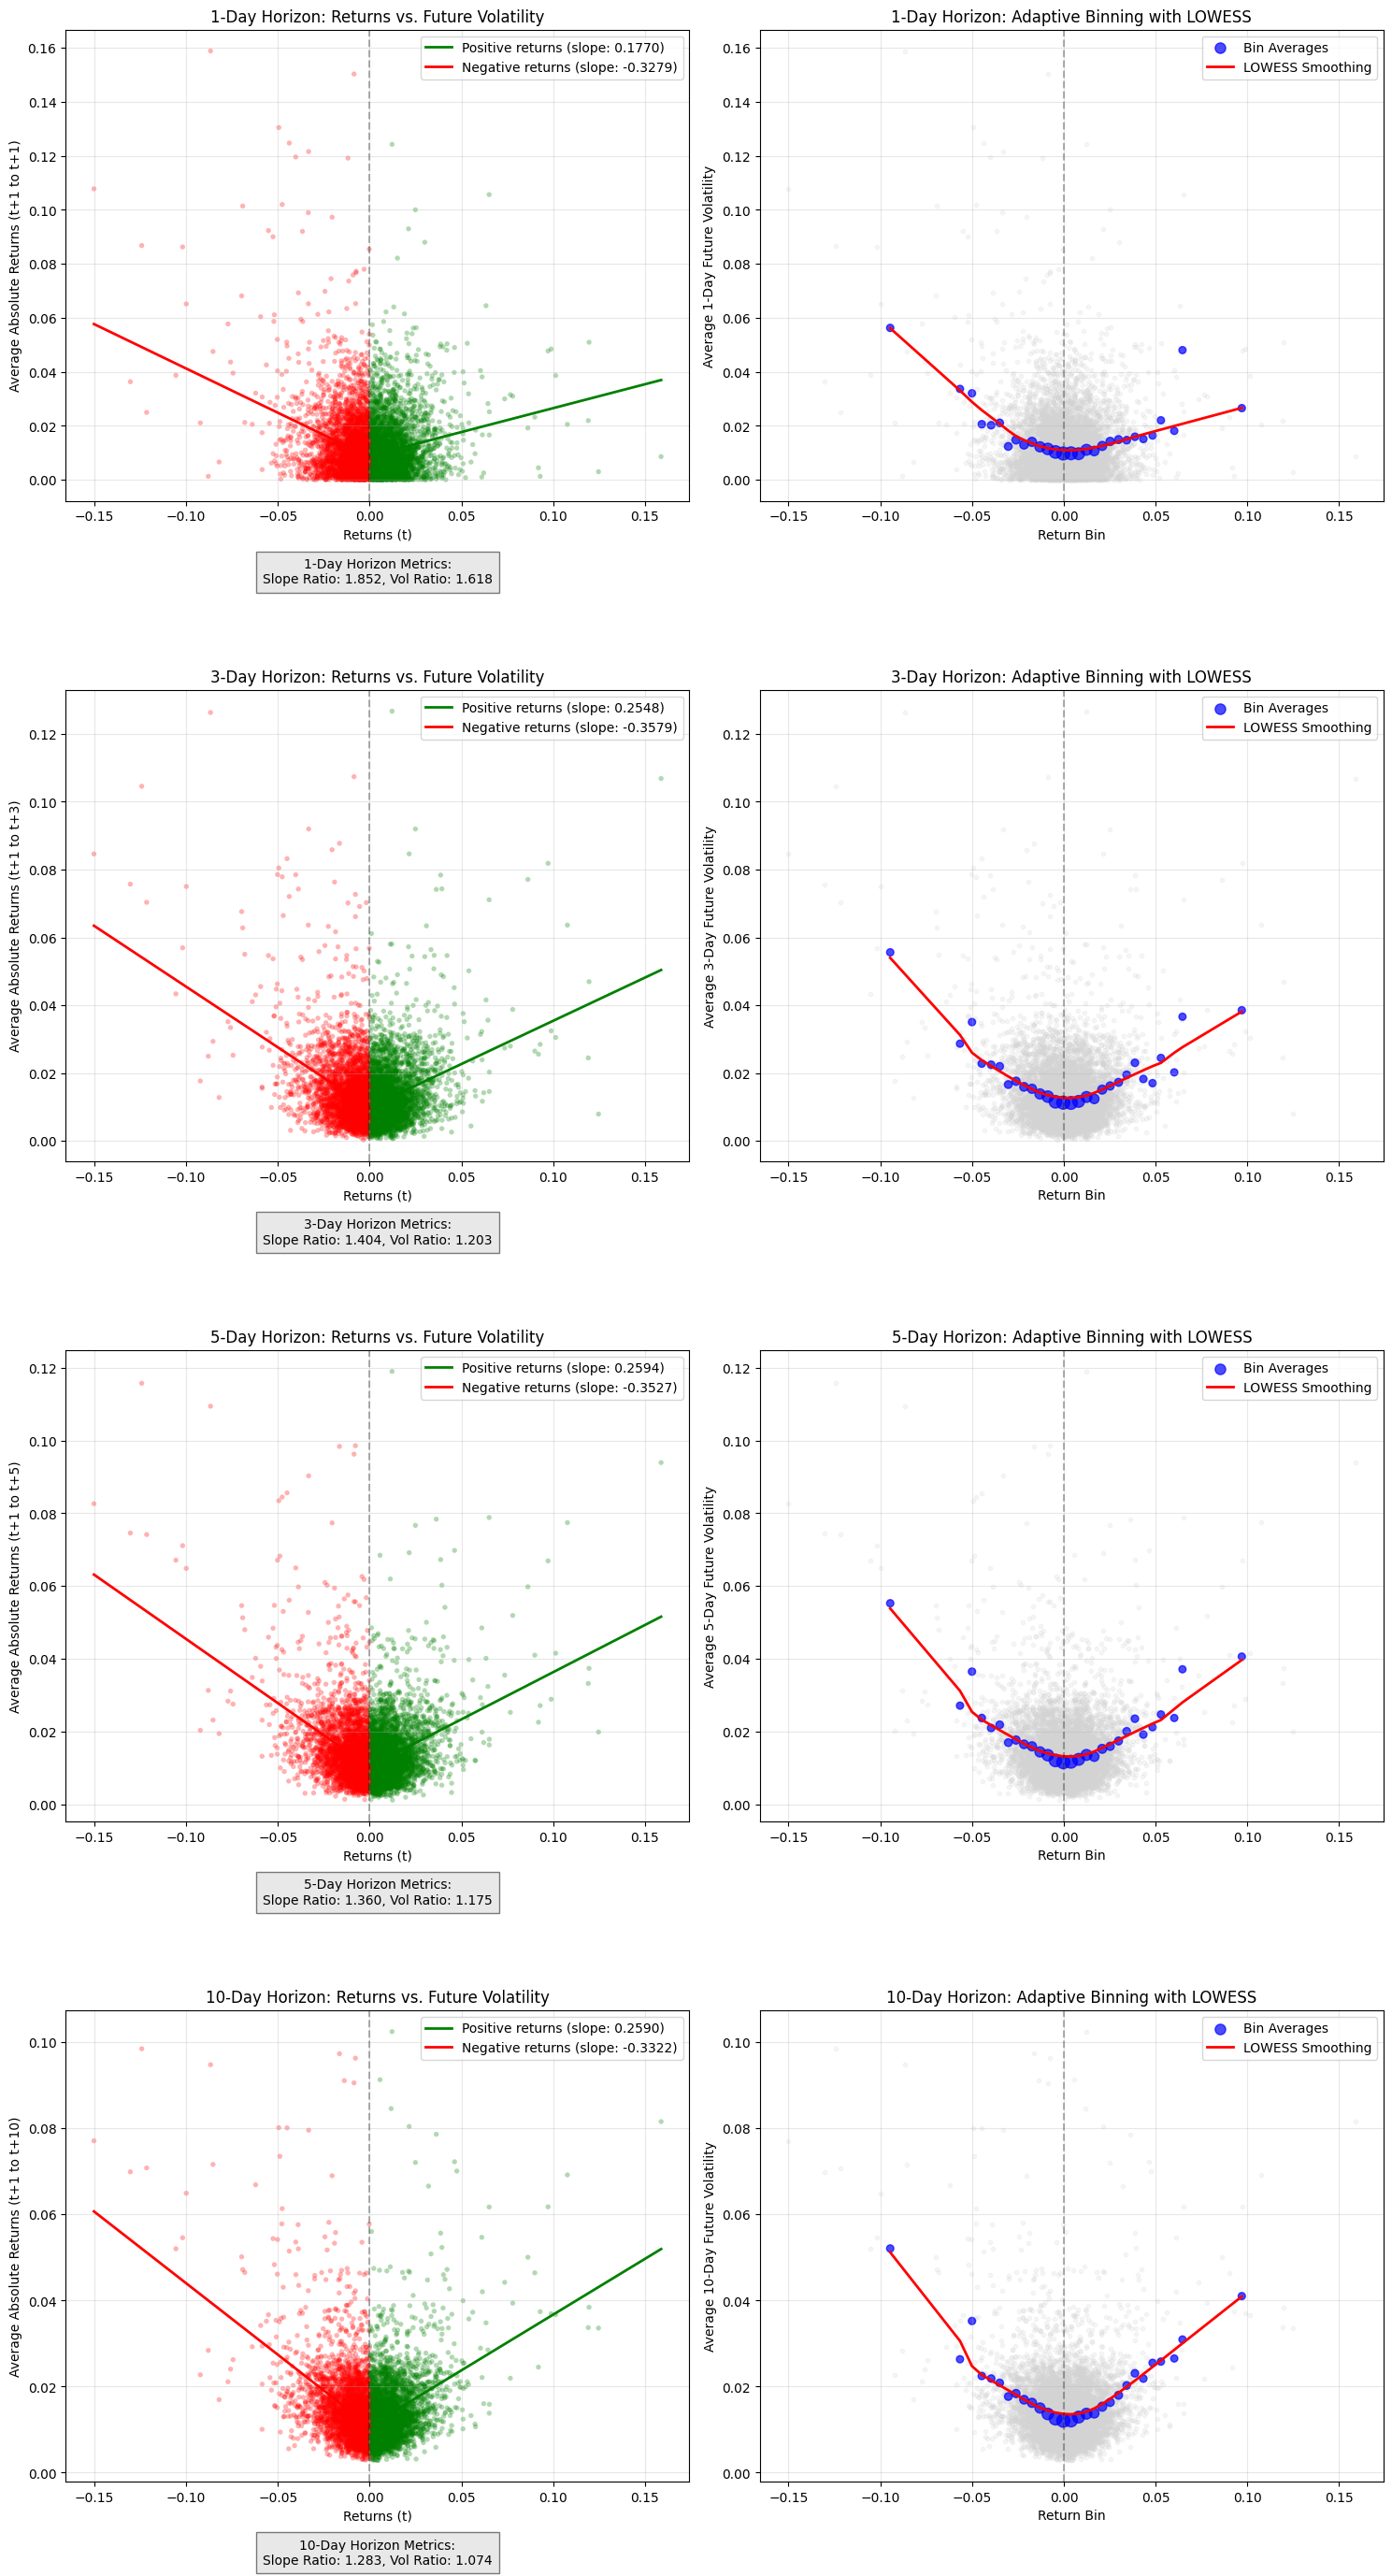

Horizon    Slope Ratio   Vol Ratio       Strength    Significant
-----------------------------------------------------------------
1-day             1.852       1.618    Very Strong            Yes
3-day             1.404       1.203    Very Strong            Yes
5-day             1.360       1.175         Strong            Yes
10-day             1.283       1.074       Moderate            Yes

Horizons with significant leverage effect: 4 out of 4 (100.0%)
Strongest effect observed at 1-day horizon

Interpretation: Moderate leverage effect observed, with varying strength across different horizons.


In [16]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Prepare data for different horizons
horizons = [1, 3, 5, 10]
fig, axes = plt.subplots(len(horizons), 2, figsize=(15, 7*len(horizons)))

# CHANGE: Create variables to store leverage effect results
multi_day_slope_ratios = {}
multi_day_vol_ratios = {}
multi_day_has_leverage = {}

for idx, horizon in enumerate(horizons):
    # Prepare data for current horizon
    current_returns = full_returns[:-horizon]
    future_volatility = np.zeros(len(full_returns)-horizon)

    # Calculate future volatility as sum of absolute returns over the horizon
    #for h in range(horizon):
    #    future_volatility += np.abs(full_returns[h+1:h+1+len(future_volatility)].values)
    # Calculate future volatility as sum of squared returns over the horizon
    for h in range(horizon):
        future_volatility += np.square(full_returns[h+1:h+1+len(future_volatility)].values)
    # Convert to volatility so that the relationship between returns and volatility is more linear
    # and the scale of the volatility is comparable with the returns
    future_volatility = np.sqrt(future_volatility / horizon)

    # Get the current row's axes
    ax1, ax2 = axes[idx]
    
    # 1. SCATTER PLOT WITH REGRESSION LINES (left plot)
    colors = ['green' if r >= 0 else 'red' for r in current_returns]
    ax1.scatter(current_returns, future_volatility, c=colors, alpha=0.3, edgecolor='none', s=15)
    
    # Add trend lines separately for positive and negative returns
    positive_returns = current_returns[current_returns >= 0]
    negative_returns = current_returns[current_returns < 0]
    positive_volatility = future_volatility[current_returns >= 0]
    negative_volatility = future_volatility[current_returns < 0]
    
    # Fit trend lines
    pos_slope, pos_intercept = np.polyfit(positive_returns, positive_volatility, 1)
    neg_slope, neg_intercept = np.polyfit(negative_returns, negative_volatility, 1)
    
    # Plot trend lines
    x_pos = np.linspace(0, positive_returns.max(), 100)
    ax1.plot(x_pos, pos_slope * x_pos + pos_intercept, 'g-', linewidth=2, 
           label=f'Positive returns (slope: {pos_slope:.4f})')
    
    x_neg = np.linspace(negative_returns.min(), 0, 100)
    ax1.plot(x_neg, neg_slope * x_neg + neg_intercept, 'r-', linewidth=2, 
           label=f'Negative returns (slope: {neg_slope:.4f})')
    
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    ax1.set_title(f"{horizon}-Day Horizon: Returns vs. Future Volatility", fontsize=12)
    ax1.set_xlabel("Returns (t)")
    ax1.set_ylabel(f"Average Absolute Returns (t+1 to t+{horizon})")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. ADAPTIVE BINNING APPROACH (right plot)
    ax2.scatter(current_returns, future_volatility, c='lightgray', alpha=0.2, s=10)
    
    # Create adaptive bin edges
    num_bins = 30
    alpha = 0.65
    linear_edges = np.linspace(current_returns.min(), current_returns.max(), num_bins+1)
    quantile_edges = np.quantile(current_returns, np.linspace(0, 1, num_bins+1))
    bin_edges = alpha * quantile_edges + (1-alpha) * linear_edges
    
    # Calculate bin statistics
    bin_centers, bin_volatility, bin_counts = [], [], []
    for i in range(num_bins):
        mask = (current_returns >= bin_edges[i]) & (current_returns < bin_edges[i+1])
        count = sum(mask)
        if count >= 5:
            bin_centers.append(np.mean(current_returns[mask]))
            bin_volatility.append(np.mean(future_volatility[mask]))
            bin_counts.append(count)
    
    bin_centers = np.array(bin_centers)
    bin_volatility = np.array(bin_volatility)
    bin_counts = np.array(bin_counts)
    
    # Plot binned data
    sizes = 30 + 70 * bin_counts / max(bin_counts)
    ax2.scatter(bin_centers, bin_volatility, c='blue', s=sizes, alpha=0.7, label='Bin Averages')
    
    # Add LOWESS smoothing
    sort_idx = np.argsort(bin_centers)
    sorted_centers = bin_centers[sort_idx]
    sorted_volatility = bin_volatility[sort_idx]
    smoothed = lowess(sorted_volatility, sorted_centers, frac=0.5, it=2)
    # Plot the LOWESS curve
    ax2.plot(smoothed[:, 0], smoothed[:, 1], 'r-', linewidth=2, label='LOWESS Smoothing')
    
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    ax2.set_title(f"{horizon}-Day Horizon: Adaptive Binning with LOWESS", fontsize=12)
    ax2.set_xlabel("Return Bin")
    ax2.set_ylabel(f"Average {horizon}-Day Future Volatility")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    
    
    # Calculate and display leverage effect metrics
    slope_ratio = abs(neg_slope / pos_slope)
    neg_mask = bin_centers < 0
    pos_mask = bin_centers > 0

    # Separate negative and positive regions of the smoothed curve
    smoothed_neg_mask = smoothed[:, 0] < 0
    smoothed_pos_mask = smoothed[:, 0] > 0
    
    if sum(smoothed_neg_mask) >= 3 and sum(smoothed_pos_mask) >= 3:
        # Calculate average smoothed volatility for negative and positive regions
        # Weight by distance from zero to give more importance to larger moves
        neg_weights = np.abs(smoothed[smoothed_neg_mask, 0])
        pos_weights = np.abs(smoothed[smoothed_pos_mask, 0])
        
        neg_vol = np.average(smoothed[smoothed_neg_mask, 1], weights=neg_weights)
        pos_vol = np.average(smoothed[smoothed_pos_mask, 1], weights=pos_weights)
        
        # Calculate volatility ratio using LOWESS smoothed values
        vol_ratio = neg_vol / pos_vol
        
        # Store results
        multi_day_slope_ratios[horizon] = slope_ratio
        multi_day_vol_ratios[horizon] = vol_ratio
        multi_day_has_leverage[horizon] = slope_ratio > 1.1 and vol_ratio > 1.05
        
        # Add metrics as text box
        axes[idx, 0].text(
            0.5, -0.15,
            f"{horizon}-Day Horizon Metrics:\nSlope Ratio: {slope_ratio:.3f}, Vol Ratio: {vol_ratio:.3f}",
            transform=axes[idx, 0].transAxes,
            ha='center', va='center',
            bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5}
        )
    

# Apply tight layout but with extra bottom margin for the text boxes
plt.tight_layout()
plt.subplots_adjust(bottom=0.05, hspace=0.4)  # Increase spacing between rows
plt.show()

# Determine overall leverage effect based on all analyses
has_leverage_effect = False
leverage_strength = "No clear"
    
# Store results for each horizon
horizon_results = []
for horizon, has_leverage in multi_day_has_leverage.items():
    if horizon in multi_day_slope_ratios and horizon in multi_day_vol_ratios:
        slope_ratio = multi_day_slope_ratios[horizon]
        vol_ratio = multi_day_vol_ratios[horizon]
        
        # Determine strength based on both metrics
        if slope_ratio > 1.4 and vol_ratio > 1.15:
            strength = "Very Strong"
        elif slope_ratio > 1.25 and vol_ratio > 1.075:
            strength = "Strong"
        elif slope_ratio > 1.1 and vol_ratio > 1.025:
            strength = "Moderate"
        else:
            strength = "Weak/None"
            
        horizon_results.append((horizon, slope_ratio, vol_ratio, strength, has_leverage))

# Print detailed results for each horizon
print(f"{'Horizon':<10}{'Slope Ratio':>12}{'Vol Ratio':>12}{'Strength':>15}{'Significant':>15}")
print("-" * 65)
for horizon, slope_ratio, vol_ratio, strength, is_significant in horizon_results:
    significance = "Yes" if is_significant else "No"
    print(f"{horizon}-day{'':<6}{slope_ratio:>12.3f}{vol_ratio:>12.3f}{strength:>15}{significance:>15}")

# Calculate overall metrics
significant_horizons = sum(1 for _, _, _, _, sig in horizon_results if sig)
total_horizons = len(horizon_results)
significant_percentage = (significant_horizons / total_horizons) * 100 if total_horizons > 0 else 0

print(f"\nHorizons with significant leverage effect: {significant_horizons} out of {total_horizons} ({significant_percentage:.1f}%)")

# Determine overall leverage effect strength
if significant_horizons == 0:
    overall_strength = "No"
    interpretation = "No evidence of leverage effect found across any time horizon."
elif significant_percentage < 50:
    overall_strength = "Weak"
    interpretation = "Limited evidence of leverage effect, present only at specific horizons."
elif all(strength in ["Strong", "Very Strong"] for _, _, _, strength, sig in horizon_results if sig):
    overall_strength = "Strong"
    interpretation = "Strong leverage effect consistently observed across multiple time horizons."
else:
    overall_strength = "Moderate"
    interpretation = "Moderate leverage effect observed, with varying strength across different horizons."

# Find strongest horizon if applicable
if significant_horizons > 0:
    strongest_horizon = max((sr, vr, h) for h, sr, vr, _, sig in horizon_results if sig)[2]
    print(f"Strongest effect observed at {strongest_horizon}-day horizon")

# Print overall assessment with concise interpretation
print(f"\nInterpretation: {interpretation}")

## Summary of Key Findings

Let's summarize the main statistical characteristics of our financial time series:

In [17]:
from IPython.display import Markdown

summary = f"""
### Key Statistical Properties of {my_stock.ticker}

1. **Distribution Characteristics**
    - Mean return is {stock_returns.mean():.6f}, close to zero but slightly {("positive" if stock_returns.mean() > 0 else "negative")}
    - {"Heavy tails with" if stock_returns.kurtosis() > 3 else "Near-normal"} excess kurtosis of {stock_returns.kurtosis():.4f} {"(much higher than a normal distribution)" if stock_returns.kurtosis() > 3 else ""}
    - {"Strongly non-normal" if p_value < 0.001 else "Moderately non-normal" if p_value < 0.05 else "Approximately normal"} distribution based on Jarque-Bera test (p-value = {p_value:.6f})
    - {"Significant" if abs(stock_returns.skew()) > 0.5 else "Slight"} skewness of {stock_returns.skew():.4f}, indicating {("positive" if stock_returns.skew() > 0 else "negative")} asymmetry

2. **Time Series Properties**
   - Returns are {"stationary" if adf_result[1] < 0.05 else "potentially non-stationary"} based on ADF test (p-value: {adf_result[1]:.6f})
   - {("Significant" if len(significant_lags) > 10 else "Some" if len(significant_lags) > 0 else "Minimal")} autocorrelation in returns {(f"with {len(significant_lags)} significant lags" if len(significant_lags) > 0 else "")}
   - {"Strong" if first_25_significant >= 15 else "Moderate" if first_25_significant >= 5 else "Weak"} autocorrelation in squared returns with {first_25_significant} significant lags in the first 25 periods
   - ARCH effects {"clearly present" if lm_pvalue < 0.01 else "likely present" if lm_pvalue < 0.05 else "not detected"} (LM test p-value = {lm_pvalue:.6f})

3. **Volatility Dynamics**
   - {("Strong" if first_25_significant >= 20 else "Moderate" if first_25_significant >= 10 else "Weak")} volatility clustering observed
   - {overall_strength} leverage effect detected across {significant_horizons} out of {total_horizons} time horizons ({significant_percentage:.1f}%)
   - Volatility persistence extends to {max([lag for lag, _ in significant_sq_lags]) if significant_sq_lags else "few"} lags
   - {f"Strongest leverage effect observed at {strongest_horizon}-day horizon" if significant_horizons > 0 else "No significant leverage effect detected at any horizon"}

These findings for {my_stock.ticker} align with the stylized facts typically observed in financial markets, particularly the non-normality of returns, volatility clustering, and the presence of ARCH effects. The analysis provides a solid foundation for more advanced modeling approaches such as GARCH models or option pricing that account for these empirical characteristics.
"""

display(Markdown(summary))


### Key Statistical Properties of XOM

1. **Distribution Characteristics**
    - Mean return is 0.000386, close to zero but slightly positive
    - Heavy tails with excess kurtosis of 7.9105 (much higher than a normal distribution)
    - Strongly non-normal distribution based on Jarque-Bera test (p-value = 0.000000)
    - Slight skewness of -0.0522, indicating negative asymmetry

2. **Time Series Properties**
   - Returns are stationary based on ADF test (p-value: 0.000000)
   - Significant autocorrelation in returns with 13 significant lags
   - Strong autocorrelation in squared returns with 25 significant lags in the first 25 periods
   - ARCH effects clearly present (LM test p-value = 0.000000)

3. **Volatility Dynamics**
   - Strong volatility clustering observed
   - Moderate leverage effect detected across 4 out of 4 time horizons (100.0%)
   - Volatility persistence extends to 100 lags
   - Strongest leverage effect observed at 1-day horizon

These findings for XOM align with the stylized facts typically observed in financial markets, particularly the non-normality of returns, volatility clustering, and the presence of ARCH effects. The analysis provides a solid foundation for more advanced modeling approaches such as GARCH models or option pricing that account for these empirical characteristics.
